Collaboration Notebook: YoloNAS Model Training for Cyclone Impact Area Detection

Project Title: YoloNAS Model for Cyclone Impact Area Detection

Objective: To train a machine learning model capable of identifying and detecting specific objects within satellite images of cyclone-affected areas, including undamaged and damaged residential and commercial buildings.

Dataset Description:

The dataset consists of satellite images captured before and after a cyclone event in various impacted areas.
Images are labeled to denote undamaged and damaged residential and commercial buildings.
Model Architecture:

We utilize YOLO (You Only Look Once) architecture due to its real-time object detection capabilities and efficiency.
YOLO-NAS (Neural Architecture Search) is employed for optimized model architecture selection, balancing accuracy and computational efficiency.


# 👩🏿‍🔧 Installations

Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes.

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

In [ ]:
%%capture
!pip install super-gradients==3.1.3

# 🏗️ Imports

In [ ]:
import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

In [ ]:
!unzip SubmissionData.zip

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

# 🗃️ Config

This class will store variables that will be used throughout the notebook

In [ ]:
%rm -rf dataset

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = './checkpoint' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'ey_challenge' #specify the experiment name

    #dataset params
    DATA_DIR = './dataset2' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'val/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'val/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['damagedcommercialbuilding', 'damagedresidentialbuilding', 'undamagedcommercialbuilding', 'undamagedresidentialbuilding'] #what class names do you have




    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco


# 🏋🏽 The Trainer

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and Dataloaders


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 213/213 [00:00<00:00, 3057.66it/s]


## 👀 See what some images look like after augmentations

Caching annotations: 100%|██████████| 198/198 [00:00<00:00, 1706.55it/s]


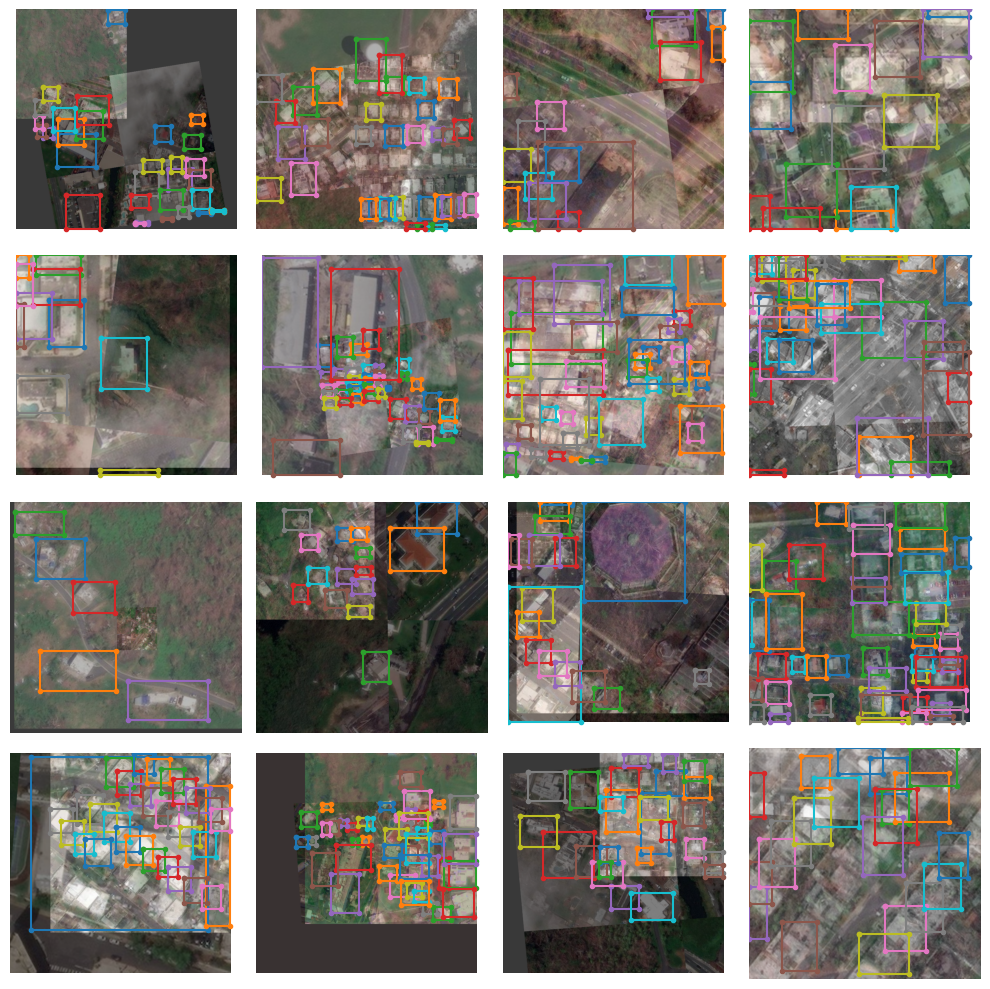

In [ ]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiate the model

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [ ]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-03-10 15:10:55] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:06<00:00, 38.4MB/s]


# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Train the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as..

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2024-03-10 16:38:09] INFO - checkpoint_utils.py - Successfully loaded model weights from ./checkpoint/ey_challenge/average_model.pth EMA checkpoint.


# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

Testing:  92%|█████████▏| 11/12 [00:11<00:00,  1.04it/s]

{'PPYoloELoss/loss_cls': 1.2044885,
 'PPYoloELoss/loss_iou': 0.20905006,
 'PPYoloELoss/loss_dfl': 1.2842107,
 'PPYoloELoss/loss': 2.3692193,
 'Precision@0.50': 0.0574948824942112,
 'Recall@0.50': 0.8199610114097595,
 'mAP@0.50': 0.3435547351837158,
 'F1@0.50': 0.10508731752634048}

Testing: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


In [ ]:
model = best_model

# 🔮 Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


[2024-03-10 17:05:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


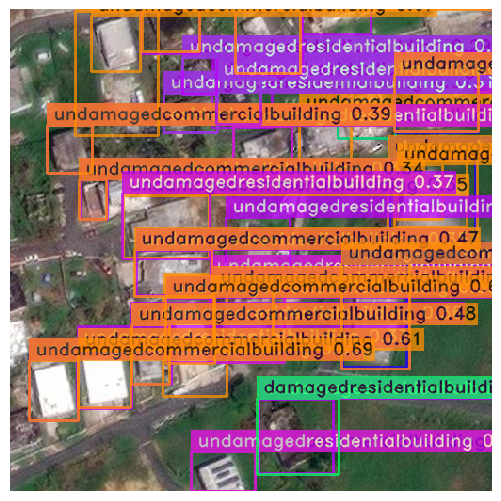

In [ ]:
result=best_model.predict( "/content/Submission data/Validation_Post_Event_001.jpg",  conf=0.25).show()

./Submission data/Validation_Post_Event_009.jpg
Making a prediction on  Validation_Post_Event_009.jpg


[2024-03-10 17:29:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


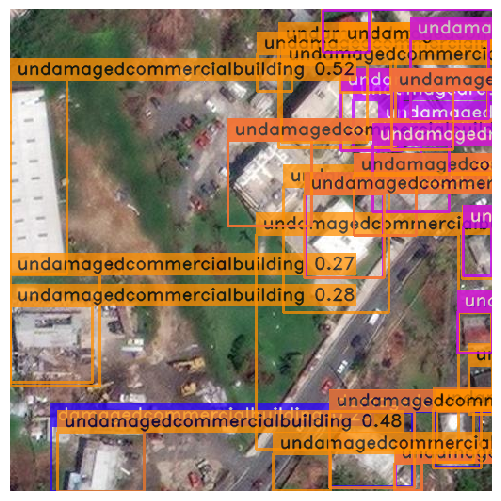

Output files generated successfully.
./Submission data/Validation_Post_Event_003.jpg
Making a prediction on  Validation_Post_Event_003.jpg


[2024-03-10 17:29:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


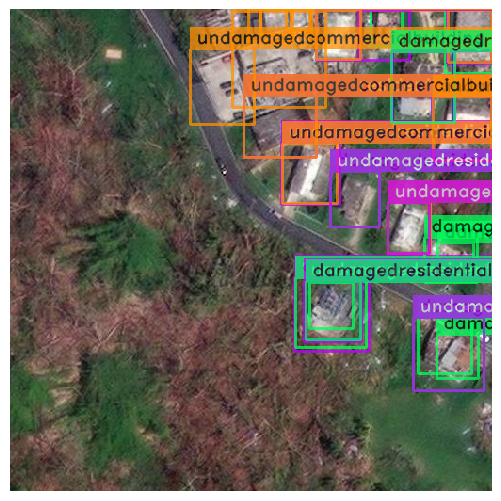

Output files generated successfully.
./Submission data/Validation_Post_Event_001.jpg
Making a prediction on  Validation_Post_Event_001.jpg


[2024-03-10 17:29:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


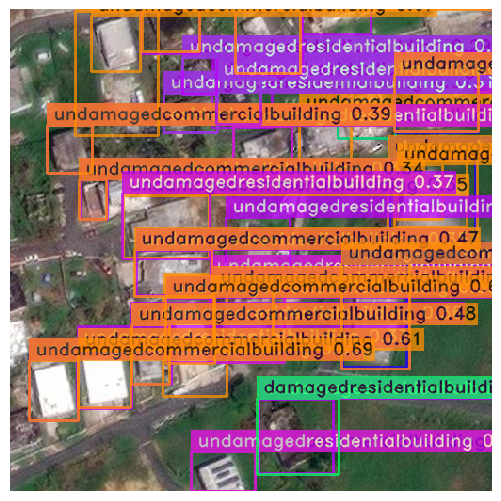

Output files generated successfully.
./Submission data/Validation_Post_Event_005.jpg
Making a prediction on  Validation_Post_Event_005.jpg


[2024-03-10 17:29:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


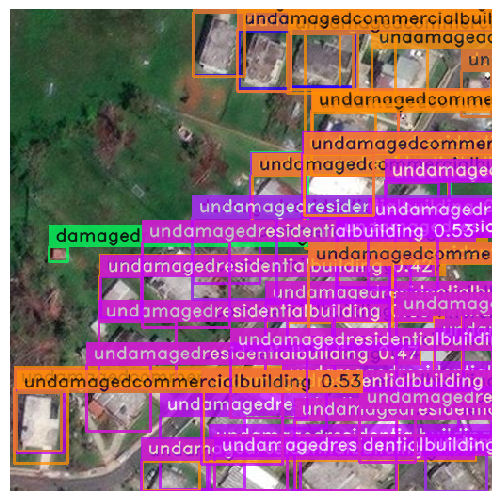

Output files generated successfully.
./Submission data/Validation_Post_Event_011.jpg
Making a prediction on  Validation_Post_Event_011.jpg


[2024-03-10 17:29:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


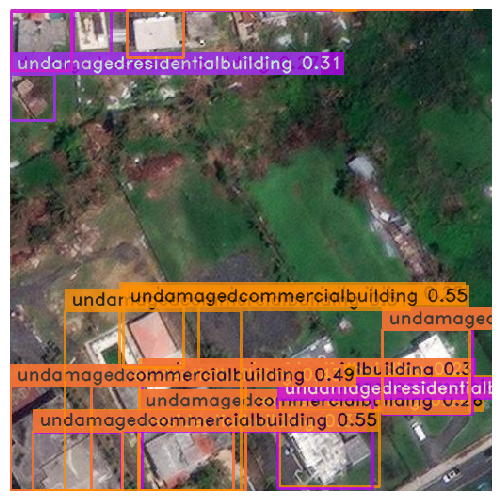

Output files generated successfully.
./Submission data/Validation_Post_Event_008.jpg
Making a prediction on  Validation_Post_Event_008.jpg


[2024-03-10 17:29:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Output files generated successfully.
./Submission data/Validation_Post_Event_012.jpg
Making a prediction on  Validation_Post_Event_012.jpg


[2024-03-10 17:29:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Output files generated successfully.
./Submission data/Validation_Post_Event_004.jpg
Making a prediction on  Validation_Post_Event_004.jpg


[2024-03-10 17:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


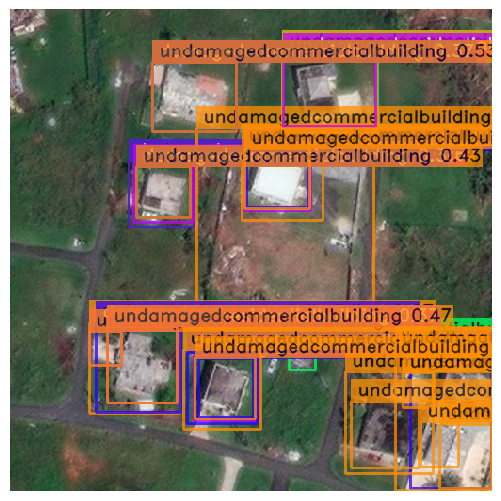

Output files generated successfully.
./Submission data/Validation_Post_Event_006.jpg
Making a prediction on  Validation_Post_Event_006.jpg


[2024-03-10 17:29:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


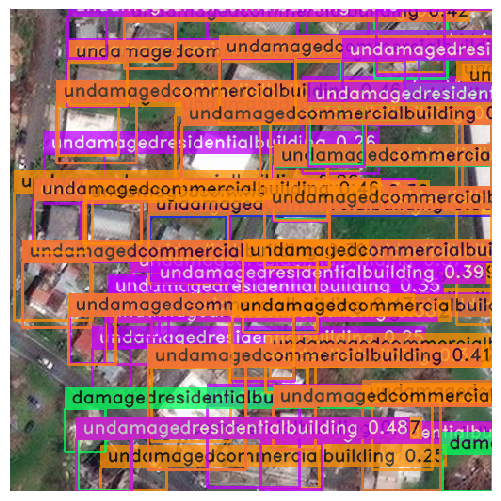

Output files generated successfully.
./Submission data/Validation_Post_Event_010.jpg
Making a prediction on  Validation_Post_Event_010.jpg


[2024-03-10 17:30:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


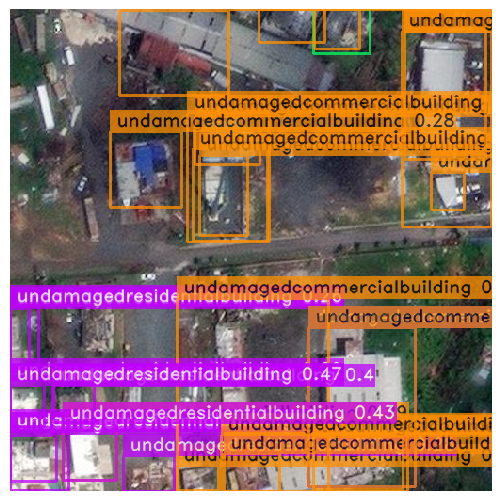

Output files generated successfully.
./Submission data/Validation_Post_Event_007.jpg
Making a prediction on  Validation_Post_Event_007.jpg


[2024-03-10 17:30:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


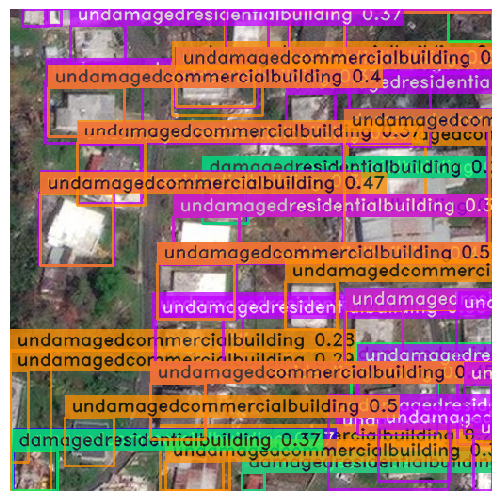

Output files generated successfully.
./Submission data/Validation_Post_Event_002.jpg
Making a prediction on  Validation_Post_Event_002.jpg


[2024-03-10 17:30:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


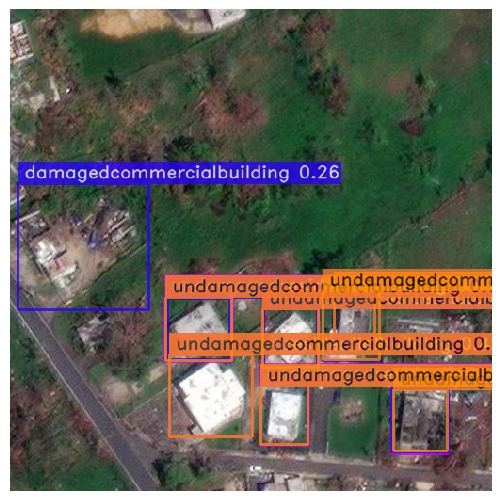

In [ ]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'damagedcommercialbuilding', 1: 'damagedresidentialbuilding', 2: 'undamagedcommercialbuilding', 3: 'undamagedresidentialbuilding'}

directory = './Submission data'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        # results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        results = model.predict(file_path,conf=0.25)
        results.show()

        for r in results:
            conf_list = r.prediction.confidence.tolist()
            clss_list = r.prediction.labels.tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.prediction.bboxes_xyxy
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


In [ ]:
import shutil


In [ ]:

import shutil
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.
